<img src="starbucks.png" style="height: 250px">

# Starbucks Capstone Challenge

### Notebook Content
- Part 1: Introduction
    - [Project Overview](#Overview)
	- [Problem Statement](#Problem-statement)
    - [Datasets](#Datasets)
- Part 2: Explanatory Data Analysis
	- [Load Packages](#Load-Packages)
	- [Load Datasets](#Load-data)
	- [Perform Data Preprocessing](#Perform-data-analysis)
- Part 3: Data Modeling

---

# 1. Introduction

<a id="Overview"></a>
## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 


<a id="#problem-statement"></a>
## Problem Statement
The goal of this project is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

<a id="#Datasets"></a>
## Datasets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

---

# 2. Explanatory Data Analysis

<a id="#Load-Packages"></a>
## Load Packages

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
%matplotlib inline

<a id="#Load-"></a>
## Load Datasets

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)


(10, 6)
(17000, 5)
(306534, 4)


<a id="#Perform-data-analysis"></a>
## Perform Data Preprocessing

### Explore Portfolio Dataset

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
# Count of each data type
portfolio.dtypes.value_counts()

int64     3
object    3
dtype: int64

In [6]:
# Handy list of all the string/text columns in the dataset
list(portfolio.select_dtypes(include=object))

['channels', 'offer_type', 'id']

In [7]:
convert_dict = {'id': str,
                'offer_type': str
               }

In [8]:
portfolio = portfolio.astype(convert_dict)

In [9]:
portfolio.describe().T.style

,count,mean,std,min,25%,50%,75%,max
reward,10.000000,4.200000,3.583915,0.000000,2.000000,4.000000,5.000000,10.000000
difficulty,10.000000,7.700000,5.831905,0.000000,5.000000,8.500000,10.000000,20.000000
duration,10.000000,6.500000,2.321398,3.000000,5.000000,7.000000,7.000000,10.000000


In [10]:
portfolio.dtypes.value_counts()

int64     3
object    3
dtype: int64

In [11]:
# Number of unique values in each column
print(portfolio[['difficulty', 'duration', 'id', 'offer_type', 'reward']].nunique())

difficulty     5
duration       5
id            10
offer_type     3
reward         5
dtype: int64


In [12]:
portfolio.rename({'id': 'offer_id'}, axis=1, inplace= True)

In [13]:
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'offer_id'],
      dtype='object')

In [14]:
# Apply one hot encoding to channels column
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [15]:
# Apply one hot encoding to offer_type 
portfolio = pd.get_dummies(portfolio , columns=['offer_type'])

In [16]:
# Drop channels column
portfolio.drop(['channels'], axis=1, inplace=True)

In [17]:
# Checking for missing values
portfolio.isnull().sum()

reward                      0
difficulty                  0
duration                    0
offer_id                    0
web                         0
email                       0
mobile                      0
social                      0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
dtype: int64

In [18]:
# Checking for duplicates
portfolio.duplicated().sum()

0

In [19]:
# Cleaned Portfolio Dataset
portfolio.head()

,reward,difficulty,duration,offer_id,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


### Explore Profile Dataset

In [20]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [21]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [22]:
profile.dtypes.value_counts()

object     2
int64      2
float64    1
dtype: int64

In [23]:
profile.describe().T.style

,count,mean,std,min,25%,50%,75%,max
age,17000.000000,62.531412,26.738580,18.000000,45.000000,58.000000,73.000000,118.000000
became_member_on,17000.000000,20167034.234118,11677.499961,20130729.000000,20160526.000000,20170802.000000,20171230.000000,20180726.000000
income,14825.000000,65404.991568,21598.299410,30000.000000,49000.000000,64000.000000,80000.000000,120000.000000


In [24]:
# check 118 age's records 
profile[profile['age']==118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


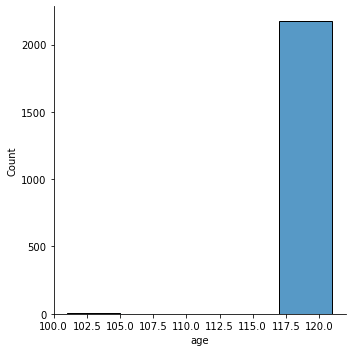

In [25]:
sns.displot(profile, x=profile[profile["age"]>100]['age'], binwidth=4)

In [26]:
profile.where(profile['age']==118).count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

`All the missing values are associated with 118 age's records, for that I will drop each record with 118 age value`

In [27]:
profile.drop(profile[profile['age'] == 118].index, inplace = True)

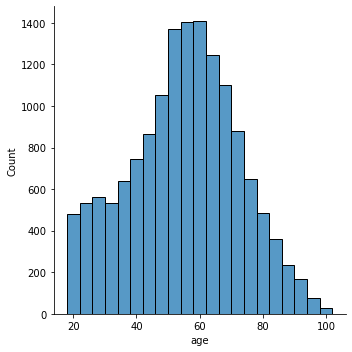

In [28]:
sns.displot(profile, x=profile["age"], binwidth=4)

In [29]:
# rename id column to customer_id
profile.rename({'id': 'customer_id'}, axis=1, inplace= True)

In [30]:
profile['became_member_on'] = profile['became_member_on'].astype(str).astype('datetime64[ns]')

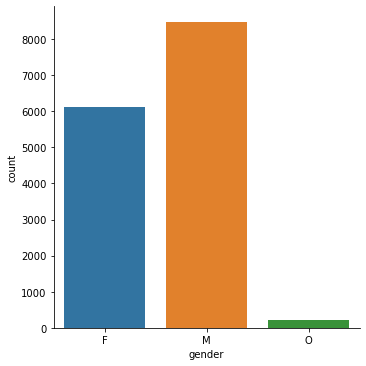

In [31]:
sns.catplot(x='gender', kind="count", data=profile)

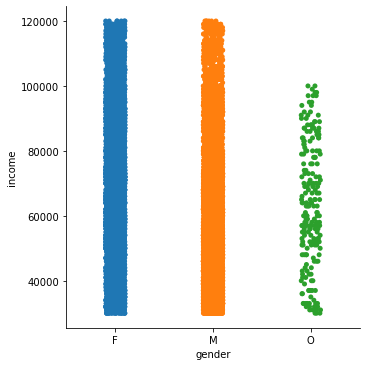

In [32]:
sns.catplot(x='gender', y='income',data=profile)

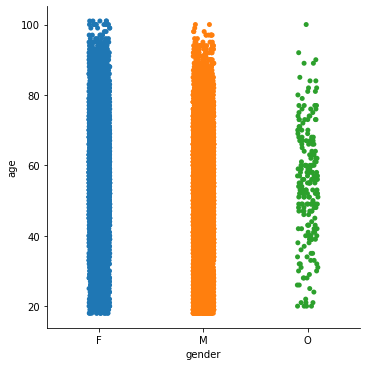

In [33]:
sns.catplot(x="gender", y="age", data=profile)

In [34]:
# Cleaned Profile Dataset
profile.head()

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


### Explore Transcript Dataset

In [35]:
transcript.head(60)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [36]:
transcript.rename({'person': 'customer_id'}, axis=1, inplace= True)

In [37]:
# Remove customer id's that are not in the customer profile DataFrame
transcript = transcript[transcript['customer_id'].isin(profile['customer_id'])]

In [38]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [39]:
transcript.head()

,customer_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


In [40]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  272762 non-null  object 
 1   event        272762 non-null  object 
 2   value        272762 non-null  object 
 3   time         272762 non-null  int64  
 4   offer id     116361 non-null  object 
 5   amount       123957 non-null  float64
 6   offer_id     32444 non-null   object 
 7   reward       32444 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 18.7+ MB


In [41]:
# clean up the duplicates in offer id and offer_id and meger into one column
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])

# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

In [42]:
# drop value column
transcript.drop('value', axis=1, inplace=True)

In [43]:
transcript.head()

,customer_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [44]:
profile.head()

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [45]:
portfolio.head()

,reward,difficulty,duration,offer_id,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


In [46]:
master_df = transcript.merge(portfolio,how='left',on='offer_id')

In [47]:
master_df = master_df.merge(profile, on = 'customer_id')

In [48]:
master_df 

,customer_id,event,time,amount,reward_x,offer_id,reward_y,difficulty,duration,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,F,75,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,F,75,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,F,75,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,M,47,2017-10-13,94000.0
272758,9fcbff4f8d7241faa4ab8a9d19c8a812,offer received,576,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,M,47,2017-10-13,94000.0
272759,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,576,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,M,47,2017-10-13,94000.0
272760,3045af4e98794a04a5542d3eac939b1f,offer received,576,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,F,58,2016-10-20,78000.0
